In [13]:
from enum import Enum
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langchain.schema import HumanMessage
from langgraph.graph import Graph
from IPython.display import Image, display

# ======================================================
# MODELLI
# ======================================================

# Definizione di un Enum Pydantic per vincolare il campo `tipo`
# L'enum assicura che il valore possa essere solo "fisica" o "giuridica"
class TipoPersona(str, Enum):
    fisica = "fisica"
    giuridica = "giuridica"

# Modello che rappresenta la risposta del primo nodo del grafo
# Serve per classificare l’anagrafica come persona fisica o giuridica.
# Il campo `tipo` è di tipo Enum (definito sopra), quindi il validatore Pydantic
# accetterà solo stringhe che corrispondono ai valori definiti nell’enum.
class PersonaOutput(BaseModel):
    tipo: TipoPersona = Field(description="Tipo di persona: 'fisica' o 'giuridica'")

## Modello intermedio usato solo per parsare l’output del modello LLM
# che divide un nome completo in due parti (nome e cognome).
# Non include il campo `tipo`, per evitare errori di validazione nel parsing.
class DettaglioNomeCognome(BaseModel):
    nome: str
    cognome: str

# Modello finale per persona fisica
# Eredita da `DettaglioNomeCognome` e aggiunge un campo `tipo`
# con valore di default "fisica".
# Il valore di default viene impostato qui perché non deve essere fornito dall’LLM,
# ma determinato logicamente dal nostro flusso (dopo la classificazione).
class DettaglioPersonaFisica(DettaglioNomeCognome):
    tipo: TipoPersona = Field(default=TipoPersona.fisica)

# Modello finale per persona giuridica
# Contiene solo la ragione sociale e il tipo predefinito "giuridica".
# Anche qui `tipo` ha un default, così da non doverlo chiedere all’LLM.
class DettaglioPersonaGiuridica(BaseModel):
    ragione_sociale: str
    tipo: TipoPersona = Field(default=TipoPersona.giuridica)

# ======================================================
# LLM
# ======================================================

# Istanzia il modello Llama 3.2 tramite Ollama, con temperatura 0
# (risposte più determinate e meno creative)
llm = ChatOllama(model="llama3.2", temperature=0)

# ======================================================
# NODI
# ======================================================

# Primo nodo: classificazione persona
# Riceve la stringa in input, chiede al modello se è fisica o giuridica
# e restituisce la risposta in formato `PersonaOutput` (validato da Pydantic).
def classifica_persona(input_str: str):
    """Determina se il testo rappresenta una persona fisica o giuridica."""
    prompt = f"""
    Determina se il seguente nome si riferisce a una persona fisica o giuridica.
    Rispondi solo con 'fisica' o 'giuridica'.

    Nome: {input_str}
    """
    result = llm.with_structured_output(PersonaOutput).invoke([HumanMessage(content=prompt)])
    # Ritorniamo sia il testo originale che la classificazione
    return {"input_str": input_str, "classificazione": result}


def elabora_fisica(data: dict):
    """Dividi il nome in nome e cognome."""
    input_str = data["input_str"]
    prompt = f"""
    Dividi il seguente nome in nome e cognome.
    Rispondi in formato JSON con le chiavi 'nome' e 'cognome'.

    Nome completo: {input_str}
    """
    parsed = llm.with_structured_output(DettaglioNomeCognome).invoke([HumanMessage(content=prompt)])
    return DettaglioPersonaFisica(**parsed.model_dump())

def elabora_giuridica(data: dict):
    """Crea output con ragione sociale."""
    input_str = data["input_str"]
    return DettaglioPersonaGiuridica(ragione_sociale=input_str)

def log_result(result):
    """Nodo di log — utile per debug o tracciamento dei risultati."""
    print("\n[LOG NODE] Risultato finale del ramo:", result.model_dump())
    return result  # Importante: deve ritornare l’oggetto per passarlo al nodo successivo (se presente)

In [16]:
# ======================================================
# 4️⃣ COSTRUZIONE GRAFO CON CONDITIONAL EDGE
# ======================================================

graph = Graph()

# Aggiunta nodi
graph.add_node("classifica", classifica_persona)
graph.add_node("elabora_fisica", elabora_fisica)
graph.add_node("elabora_giuridica", elabora_giuridica)
graph.add_node("log", log_result)

# Entry point
graph.set_entry_point("classifica")

# Funzione di routing
def routing_function(data: dict):
    tipo = data["classificazione"].tipo
    if tipo == TipoPersona.fisica:
        return "elabora_fisica"
    else:
        return "elabora_giuridica"

# Conditional edge per instradamento
graph.add_conditional_edges("classifica", routing_function)

# Aggiungiamo il nodo di log prima della fine per entrambi i rami
graph.add_edge("elabora_fisica", "log")
graph.add_edge("elabora_giuridica", "log")

# Nodo finale
graph.set_finish_point("log")

# Compila il grafo
app = graph.compile()

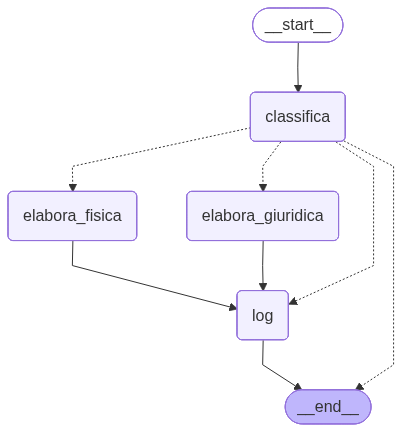

In [17]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [41]:
# ======================================================
# TEST
# ======================================================

for test in ["Michele Soncini", "Alfa S.R.L.", "Mario Russo"]:
    print(f"\n🧩 INPUT: {test}")
    result = app.invoke(test)
    print("📤 OUTPUT:", result.model_dump_json(indent=2))



🧩 INPUT: Michele Soncini
nome='Michele' cognome='Soncini'
[LOG] Risultato finale: {'nome': 'Michele', 'cognome': 'Soncini', 'tipo': <TipoPersona.fisica: 'fisica'>}
📤 OUTPUT: {
  "nome": "Michele",
  "cognome": "Soncini",
  "tipo": "fisica"
}

🧩 INPUT: Alfa S.R.L.
[LOG] Risultato finale: {'ragione_sociale': 'Alfa S.R.L.', 'tipo': <TipoPersona.giuridica: 'giuridica'>}
📤 OUTPUT: {
  "ragione_sociale": "Alfa S.R.L.",
  "tipo": "giuridica"
}

🧩 INPUT: Mario Russo
nome='Mario' cognome='Russo'
[LOG] Risultato finale: {'nome': 'Mario', 'cognome': 'Russo', 'tipo': <TipoPersona.fisica: 'fisica'>}
📤 OUTPUT: {
  "nome": "Mario",
  "cognome": "Russo",
  "tipo": "fisica"
}
